Descripción
===========

Felicidades! Eres el orgulloso propietario de 5 robots nuevos y un almacén lleno de cajas. El dueño anterior del almacén lo dejó en completo desorden, por lo que depende de tus robots organizar las cajas en algo parecido al orden y convertirlo en un negocio exitoso.

Cada robot está equipado con ruedas omnidireccionales y, por lo tanto, puede conducir en las cuatro direcciones. Pueden recoger cajas en celdas de cuadrícula adyacentes con sus manipuladores, luego llevarlas a otra ubicación e incluso construir pilas de hasta cinco cajas. Todos los robots están equipados con la tecnología de sensores más nueva que les permite recibir datos de sensores de las cuatro celdas adyacentes. Por tanto, es fácil distinguir si un campo está libre, es una pared, contiene una pila de cajas (y cuantas cajas hay en la pila) o está ocupado por otro robot. Los robots también tienen sensores de presión equipados que les indican si llevan una caja en ese momento.

Lamentablemente, tu presupuesto resultó insuficiente para adquirir un software de gestión de agentes múltiples de última generación. Pero eso no debería ser un gran problema ... ¿verdad? Tu tarea es enseñar a sus robots cómo ordenar su almacén. La organización de los agentes depende de ti, siempre que todas las cajas terminen en pilas ordenadas de cinco.

### Puntos a considerar

-   La semilla para generación de números aleatorios será 67890.
-   El almacén es 20x20 celdas.
-   Al inicio de la simulación, tu solución deberá colocar 200 cajas repartidas en grupos de 1 a 3 cajas en posiciones aleatorias.
-   Todos los robots empiezan en posiciones aleatorias vacías. Y, sólo puede haber un robot por celda.
-   La simulación termina cuando todas las cajas se encuentra apiladas en pilas de exactamente 5 cajas.

### ¿Que debes entregar?

Un cuaderno de Jupyter Notebook conteniendo un reporte de la actividad. El cuaderno deberá contener:

-   Código fuente documentado.
-   Descripción detallada de la estrategia y los mecanismos utilizados en tu solución.
-   Una visualización que permita ver los diferentes pasos de la simulación.
-   El número de pasos necesarios para terminar la simulación.
-   ¿Existe una forma de reducir el número de pasos utilizados? Si es así, ¿cuál es la estrategia que se tendría en implementar?

Criterios de evaluación
=======================

Los criterios que se utilizarán para evaluar sus soluciones y seleccionar a los tres primeros ganadores son los siguientes:

- Aplicación original, innovadora y efectiva de algoritmos computacionales para resolver problemas específicos.

- El rendimiento de la implementación. El rendimiento de la implementación se medirá en función los pasos necesarios para terminar la simulación.

- La calidad de la descripción de análisis, diseño e implementación del sistema multiagente, la elegancia de su diseño e implementación.

Author: Santiago Rodriguez Murialdo

Matricula: A01704109

Date: 17/11/2023

In [668]:
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import numpy as np
import random

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

random.seed(67890)

In [669]:
'''
Agente de tipo caja que solo nos sirve para 
ponerla dentro de nuestro grid para que el robot
pueda identificarla como su vecino
'''

class Box(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.type = 1

In [670]:
'''
Agente de tipo robot, el cual va a realizar las tareas
que estamos buscando. Este puede moverse solo en 4 direcciones
pero puede buscar cajas en 8 direcciones. Tiene la habilidad de
cargar una caja a la vez y de llevarla a una torre. De igual manera
se comunica con los otros agentes de su tipo para poder realizar busquedas
cajas y torres de manera mas eficiente. Estos se comunican para decirse
cuales son sus torres para que los demas no lleven cajas ahi.
'''

class Robot(Agent):
    # Constructor
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.type = 2 # Tipo para identificarlo
        self.box_carried = False # Bandera para saber si lleva una caja
        self.box_carried_id = None # ID de la caja que lleva
        self.has_tower = False # Bandera para saber si tiene una torre
        self.tower_flag = False # Bandera para saber si esta buscando una torre
        self.tower_dest_coord = None # Coordenadas de la torre que busca
        self.tower_coord = None # Coordenadas de la torre que tiene
        self.box_flag = False # Bandera para saber si esta buscando una caja
        self.box_coord = None # Coordenadas de la caja que busca

    
    # Funcion para encontrar la caja mas cercana 
    # de todas las cajas conocidas y que no sean torres
    def findNearestBox(self):
        distances = []
        for (contents, (x, y)) in self.model.grid.coord_iter():
            if any(isinstance(c, Box) for c in contents):
                distance = self.calculate_distance(self.pos, (x, y))
                distances.append((distance, (x, y)))
        
        filtered_distances = [] # Distancias que no sean torres
        for distance in distances:
            if distance[1] in self.model.towers:
                continue
            else:
                filtered_distances.append(distance)
        filtered_distances.sort(key=lambda tup: tup[0])

        if len(filtered_distances) > 0:
            return filtered_distances[0][1]
        else:
            self.moveRandom()
    
    # Funcion para calcular la distancia de Manhatan entre dos puntos
    def calculate_distance(self, pos_agent, pos_box):
        x1, y1 = pos_agent
        x2, y2 = pos_box
        return abs(x1 - x2) + abs(y1 - y2)

    # Funcion para moverse a una caja
    def move2box(self, box_pos):
        # Si no pasamos posicion
        if box_pos is None:
            self.moveRandom()
            return

        x, y = self.pos
        target_x, target_y = box_pos

        # Si ya estamos en la posicion
        if self.pos == box_pos:
            self.moveRandom()
            return

        # Potencial nueva posicion
        new_x, new_y = x, y

        if abs(x - target_x) > abs(y - target_y):
            if x < target_x:
                new_x += 1
            elif x > target_x:
                new_x -= 1
        else:
            if y < target_y:
                new_y += 1
            elif y > target_y:
                new_y -= 1

        # Checar si la nueva posicion esta ocupada
        new_position_contents = self.model.grid.get_cell_list_contents((new_x, new_y))
        if any(isinstance(agent, Box) for agent in new_position_contents):
            self.moveRandom()
            return

        # Mover el agente
        self.model.grid.move_agent(self, (new_x, new_y))

    # Funcion para moverse aleatoriamente
    def moveRandom(self):
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
        possible_steps_list = list(possible_steps)

        for step in possible_steps_list:
            if self.model.boxes[step[0]][step[1]] != 0:
                possible_steps_list.remove(step)

        new_position = random.choice(possible_steps_list)
        self.model.grid.move_agent(self, new_position)

    # Funcion para buscar una torre
    def look4tower(self):
        neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        has_box = False
        for neighbor in neighbors:
            if isinstance(neighbor, Box):
                has_box = True
        if has_box:
            # Se llama a marcar una torre dentro de los vecinos si hay caja
            self.markTower()
        else:
            # Se busca la caja mas cercana si no hay caja
            if self.tower_flag == False:
                nearest_tower_pos = self.findNearestBox()
                self.move2box(nearest_tower_pos)
            else:
                self.move2box(self.tower_dest_coord)

    # Funcion para marcar una torre
    # Se busca la torre con mas cajas dentro de los vecinos
    # Si no esta marcada, se marca
    # Si todas las torres estan marcadas, se busca la torre mas cercana
    def markTower(self):
        possibles = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        
        # Get Neighbors Positions
        positions = set()
        for possible in possibles:
            pos = possible.pos
            positions.add(pos)
        
        
        positions = list(positions)
        positions_to_keep = []
        for pos in positions:
            if pos not in self.model.towers:
                positions_to_keep.append(pos)

        positions = positions_to_keep
        
        # Get the highest box count from neighbors
        if len(positions) > 0:
            count = 0
            tower_pos = None
            for position in positions:
                box_count  = self.model.boxes[position[0]][position[1]]
                if box_count > count:
                    count = box_count
                    tower_pos = position
                    self.tower_coord = tower_pos

            # Mark the tower
            self.has_tower = True
            self.model.towers.append(tower_pos)
        else:
            if self.tower_flag == False:
                nearest_tower_pos = self.findNearestBox()
                self.move2box(nearest_tower_pos)
            else:
                self.move2box(self.tower_dest_coord)
       
    # Funcion para buscar una caja
    def look4Box(self): 
        neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        box_neighbor = []

        for neighbor in neighbors:
            if isinstance(neighbor, Box):
                box_neighbor.append(neighbor)

        box_coords = []
        for box in box_neighbor:
            box_coords.append(box.pos)

        box_coords = list(set(box_coords))
        for tower in self.model.towers:
            if tower in box_coords:
                box_coords.remove(tower)

        if len(box_coords) > 0:
            box_pos = random.choice(box_coords)
            box = self.model.grid.get_cell_list_contents([box_pos])[0]
            self.model.pick_box(box.pos)
            self.box_carried_id = box.unique_id
            self.box_carried = True

        else:
            if self.box_flag == False:
                nearest_box_pos = self.findNearestBox()
                self.box_flag = True
                self.box_coord = nearest_box_pos
                self.move2box(nearest_box_pos)
            else:
                self.move2box(self.box_coord)

    # Funcion para moverse a una torre
    def checkTower(self):
        if self.model.boxes[self.tower_coord[0]][self.tower_coord[1]] == 5:
            self.has_tower = False
            self.tower_coord = None

    # Funcion para moverse a una torre
    def move2tower(self):
        # Esto se usa por si ya no hay mas torres disponibles
        if self.tower_coord is not None:
            x1, y1 = self.pos
            x2, y2 = self.tower_coord

            if (x1 + 1 == x2 or x1 - 1 == x2) and (y1 + 1 == y2 or y1 - 1 == y2):
                self.model.drop_box(self.tower_coord, self.box_carried_id)
                self.checkTower()
                self.box_carried = False
                self.has_locked_box = False
                self.box_flag = False
                self.box_coord = None
                return
            
            if (x1 + 1 == x2 or x1 - 1 == x2) and y1 == y2:
                self.model.drop_box(self.tower_coord, self.box_carried_id)
                self.checkTower()
                self.box_carried = False
                self.has_locked_box = False
                self.box_flag = False
                self.box_coord = None
                return
            
            if (y1 + 1 == y2 or y1 - 1 == y2) and x1 == x2:
                self.model.drop_box(self.tower_coord, self.box_carried_id)
                self.checkTower()
                self.box_carried = False
                self.has_locked_box = False
                self.box_flag = False
                self.box_coord = None
                return

            if x1 < x2:
                x1 += 1
                self.model.grid.move_agent(self, (x1, y1))
                return
            elif x1 > x2:
                x1 += -1
                self.model.grid.move_agent(self, (x1, y1))
                return
            elif y1 < y2:
                y1 += 1
                self.model.grid.move_agent(self, (x1, y1))
                return
            elif y1 > y2:
                y1 += -1
                self.model.grid.move_agent(self, (x1, y1))
                return
        else:
            return
    
    def step(self):
        # Si no tiene caja y no tiene torre
        if not self.box_carried and not self.has_tower:
            self.look4tower()
        # Si tiene caja y no tiene torre
        elif not self.box_carried and self.has_tower:
            self.look4Box()
        # Si tiene caja y tiene torre
        elif self.box_carried and self.has_tower:
            self.move2tower()

In [671]:
# Funcion para obtener el grid de la simulacion y poder graficarlo
def get_grid(model):
    grid = np.zeros((model.width, model.height))
    for (contents, (x, y)) in model.grid.coord_iter():
        for content in contents:
            # Si es una caja
            if isinstance(content, Box):
                grid[x][y] = model.boxes[x][y] # Cantidad de cajas
            # Si es un robot
            elif isinstance(content, Robot):
                grid[x][y] = 10 # Valor para identificarlo
    return grid

In [672]:
'''
Modelo de la simulacion, el cual contiene el grid, el schedule
y el datacollector. Ademas de esto, contiene las funciones para
colocar los agentes en el grid, para saber si una celda esta vacia,
para saber si una celda tiene una caja, para saber si una torre esta
llena, para tomar una caja, para dejar una caja, para obtener una
posicion aleatoria, para obtener una celda aleatoria, para obtener
una posicion aleatoria, para saber si la simulacion ya termino y para
avanzar un step.
'''

class WarehouseModel(Model):
    def __init__(self, width, height, num_agents, num_boxes):
        # Constantes
        self.width = width
        self.height = height
        self.num_agents = num_agents
        self.num_boxes = num_boxes
        self.random.seed(67890)

        # Variables usadas por los agentes
        self.boxes = np.zeros((width, height))
        self.known_boxes = np.zeros((width, height))
        self.towers = []

        # Variables exclusivas del modelo
        self.grid = MultiGrid(width, height, torus=False)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})

        # Variables para la simulacion
        self.steps = 0

        # Colocar los robots
        robotId = 0
        robot_positions = [] # Posiciones de los robots
        for _ in range(self.num_agents):
            a = Robot(robotId, self)
            self.schedule.add(a)
            pos = self.random_empty_cell()
            while self.is_box(pos):
                pos = self.random_empty_cell()
            robot_positions.append(pos)
            self.grid.place_agent(a, pos)
            robotId += 1

        # COlocar las cajas
        boxId = 10
        for _ in range(self.num_boxes):
            b = Box(boxId, self)
            self.schedule.add(b)
            pos = self.random_box_cell(robot_positions)
            while self.init_full(pos):
                pos = self.random_box_cell(robot_positions)
            self.grid.place_agent(b, pos)
            self.boxes[pos[0]][pos[1]] += 1
            boxId += 1

    # Funcion para saber si una celda es una caja          
    def is_box(self, pos):
        return self.boxes[pos[0]][pos[1]] > 0
    
    # Funcion para saber si una celda tiene 3 cajas
    def init_full(self, pos):
        return self.boxes[pos[0]][pos[1]] == 3
    
    # Funcion para saber si una torre esta llena
    def is_tower_full(self, pos):
        return self.boxes[pos[0]][pos[1]] == 5

    # Funcion que usa el agente para recoger una caja
    def pick_box(self, pos):
        self.boxes[pos[0]][pos[1]] -= 1
        self.grid.remove_agent(self.grid.get_cell_list_contents(pos)[0])

    # Funcion que usa el agente para dejar una caja
    def drop_box(self, pos, unique_id):
        b = Box(unique_id, self)
        self.boxes[pos[0]][pos[1]] += 1
        self.grid.place_agent(b, pos)

    # Funcion que usan las cajas en su creacion para obtener una posicion aleatoria
    def random_box_cell(self, robot_pos):
        empty_cells = [(x, y) for x in range(self.width) for y in range(self.height)]
        available_cells = [cell for cell in empty_cells if cell not in robot_pos]
        if not available_cells:
            raise Exception("No empty cells available.")
        return random.choice(available_cells)

    # Funcion que usan los robots para obtener una posicion aleatoria   
    def random_empty_cell(self):
        empty_cells = [(x, y) for x in range(self.width) for y in range(self.height) if self.grid.is_cell_empty((x, y))]
        if not empty_cells:
            raise Exception("No empty cells available.")
        return random.choice(empty_cells)
    
    # Funcion para saber si la simulacion ya termino
    def is_simulation_done(self):
        # Un rango por que hay veces que los agentes marcan una torre y no la llenan
        if (len(self.towers) in range(40, 45)): 
            return True
        else:
            return False

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        if not self.is_simulation_done():
            self.steps += 1
        

In [673]:
# Constantes
WIDTH = 20
HEIGHT = 20
NUM_AGENTS = 5
NUM_BOXES = 200

In [674]:
model = WarehouseModel(WIDTH, HEIGHT, NUM_AGENTS, NUM_BOXES)
for i in range(350):
    model.step()

data = model.datacollector.get_model_vars_dataframe()

43


C:\Users\santi\AppData\Local\Temp\ipykernel_6056\1414769870.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch = plt.imshow(data.iloc[0][0], cmap=plt.cm.binary)
C:\Users\santi\AppData\Local\Temp\ipykernel_6056\1414769870.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(data.iloc[frame][0])


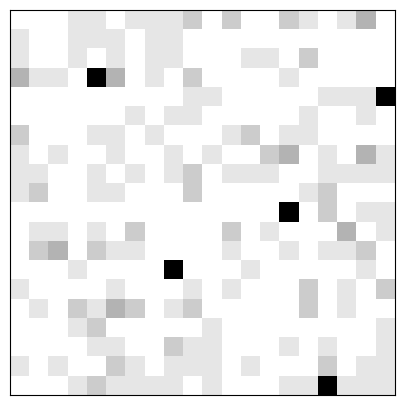

In [675]:
fig, axis = plt.subplots(figsize=(5, 5))
axis.set_xticks([])
axis.set_yticks([])
patch = plt.imshow(data.iloc[0][0], cmap=plt.cm.binary)

def animate(frame):
    patch.set_data(data.iloc[frame][0])
steps = model.steps
print(len(model.towers))
anim = animation.FuncAnimation(fig , animate, frames=350, interval=100)

In [676]:
print("Steps: ", model.steps)
anim

C:\Users\santi\AppData\Local\Temp\ipykernel_6056\1414769870.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(data.iloc[frame][0])


Steps:  144


# **Reflexion**


Al sumergirme en la implementación de un modelo multiagente simulando la dinámica de robots en un almacén, he adquirido valiosas perspectivas sobre cómo estos sistemas pueden capturar la complejidad de interacciones entre múltiples agentes en un entorno específico. La simulación representa un escenario realista en el que los robots deben cooperar para realizar tareas como la búsqueda y colocación de cajas en torres. Este ejercicio ha brindado una visión práctica de los desafíos y las estrategias asociadas con la coordinación y toma de decisiones descentralizada en entornos dinámicos.

Un aspecto destacado es la necesidad crítica de coordinación entre los agentes para optimizar la eficiencia del sistema. La comunicación entre los robots, compartiendo información sobre la ubicación de cajas y torres, demuestra ser esencial para evitar redundancias y maximizar la eficacia en la realización de tareas. La capacidad de los agentes para realizar búsquedas y marcar torres sin depender de una supervisión central resalta la naturaleza descentralizada y autónoma de los sistemas multiagente.

La simulación también refleja la importancia de la toma de decisiones descentralizada. Cada robot toma decisiones basadas en información local, lo que refleja la realidad de muchos sistemas en el mundo real. Esta característica destaca la flexibilidad y adaptabilidad de los modelos multiagente para modelar sistemas complejos en los que la toma de decisiones no está centralizada.

A medida que considero aplicaciones futuras, me doy cuenta de que este modelo podría expandirse mediante la implementación de estrategias más avanzadas. La optimización de rutas es una vía clara de mejora; algoritmos de búsqueda de caminos más sofisticados podrían permitir a los robots encontrar las cajas y torres de manera más eficiente. Además, explorar técnicas de aprendizaje por refuerzo podría llevar la simulación a un nivel superior, permitiendo que los agentes aprendan y mejoren sus estrategias con el tiempo.

En cuanto a la pregunta sobre la reducción del número de pasos, una estrategia clave podría ser la implementación de algoritmos avanzados para la búsqueda de cajas y torres. Actualmente, la elección de la caja más cercana se basa en conocimiento local; sin embargo, la integración de algoritmos como A* o Dijkstra podría optimizar significativamente las rutas de búsqueda. Asimismo, la coordinación más avanzada entre los robots, evitando duplicidades en la búsqueda y colocación de cajas, podría contribuir a una ejecución más eficiente del sistema.

En resumen, esta experiencia con modelos multiagente en el contexto de un almacén robótico ha sido reveladora. Ha fortalecido mi comprensión de la coordinación descentralizada, la toma de decisiones autónoma y las posibles estrategias para mejorar la eficiencia en sistemas complejos. Estoy entusiasmado con la perspectiva de aplicar estos conceptos en futuros proyectos, explorando aún más el potencial de los modelos multiagente en la resolución de problemas del mundo real.